In [408]:
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
# import graphviz
# Scaling with Minmax-scaler
from sklearn.preprocessing import MinMaxScaler

# from ydata_profiling import ProfileReport

# import custom functions
from custom_functions import our_metrics

# import custom scorers
from custom_functions import get_kappa

# pd.set_option('display.max_rows', None)

from scipy.stats import loguniform

RSEED = 42

## Importing the Data

In [123]:
# reading in the data sets (for distance based models with dropped first column during dummy creation in order to avoid collinearity)
X_test = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_dropped_first.csv', delimiter=',')
X_train = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_dropped_first.csv', delimiter=',')
y_test = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv', delimiter=',')
y_train = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv', delimiter=',')

In [124]:
# importing cat DataFrames
X_test_cats = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_cats_dropped.csv', delimiter=',')
X_train_cats = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_cats_dropped.csv', delimiter=',')
y_test_cats = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test_cats.csv', delimiter=',')
y_train_cats = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train_cats.csv', delimiter=',')

In [125]:
# importing cat DataFrames
X_test_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_dogs_dropped.csv', delimiter=',')
X_train_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_dogs_dropped.csv', delimiter=',')
y_test_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test_dogs.csv', delimiter=',')
y_train_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train_dogs.csv', delimiter=',')

### Splitting DataFrames into Cats and Dogs 

In [126]:
# X_train_cats = X_train.query("type == 1").drop('type', axis=1) # 0 dog, 1 cat
# X_train_dogs = X_train.query("type == 0").drop('type', axis=1)
# X_test_cats = X_test.query("type == 1").drop('type', axis=1)
# X_test_dogs = X_test.query("type == 0").drop('type', axis=1)

In [127]:
# ix_train_cats = X_train_cats.index.to_list()
# ix_train_dogs = X_train_dogs.index.to_list()
# ix_test_cats = X_test_cats.index.to_list()
# ix_test_dogs = X_test_dogs.index.to_list()

In [128]:
# y_train_cats = y_train.loc[y_train.index[ix_train_cats]]
# y_train_dogs = y_train.loc[y_train.index[ix_train_dogs]]
# y_test_cats = y_train.loc[y_train.index[ix_test_cats]]
# y_test_dogs = y_train.loc[y_train.index[ix_test_dogs]]

In [129]:
# change format of y from dataframe to array
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)
y_train_cats = np.ravel(y_train_cats)
y_train_dogs = np.ravel(y_train_dogs)
y_test_cats = np.ravel(y_test_cats)
y_test_dogs = np.ravel(y_test_dogs)

## Predictive Modelling with a Logistic Regression

### Default Logistic Regression

In [130]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3872
_____________________
Weighted Quadratic Kappa: 0.2909


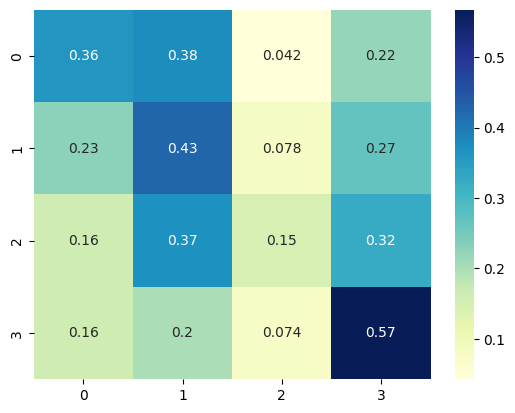

In [131]:
our_metrics(y_train, y_pred_train, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3938
_____________________
Weighted Quadratic Kappa: 0.2989


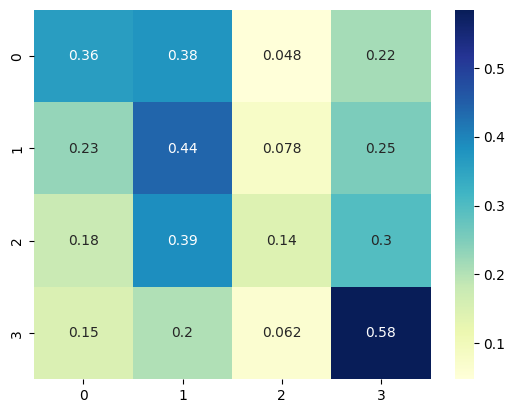

In [132]:
our_metrics(y_test, y_pred_test, normalize=True)

### Default Logistic Regression for Cats and Dogs Separately

In [392]:
# Logistic Regression
log_reg_cats = LogisticRegression(max_iter=1000)
log_reg_cats.fit(X_train_cats, y_train_cats)

log_reg_dogs = LogisticRegression(max_iter=1000)
log_reg_dogs.fit(X_train_dogs, y_train_dogs)

y_pred_train_cats = log_reg_cats.predict(X_train_cats)
y_pred_test_cats = log_reg_cats.predict(X_test_cats)

y_pred_train_dogs = log_reg_dogs.predict(X_train_dogs)
y_pred_test_dogs = log_reg_dogs.predict(X_test_dogs)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3814
_____________________
Weighted Quadratic Kappa: 0.2672


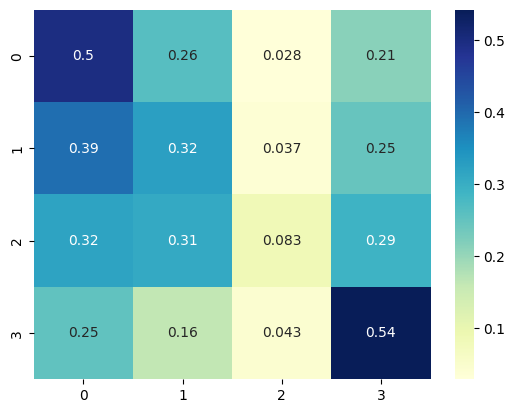

In [393]:
our_metrics(y_train_cats, y_pred_train_cats, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4035
_____________________
Weighted Quadratic Kappa: 0.3617


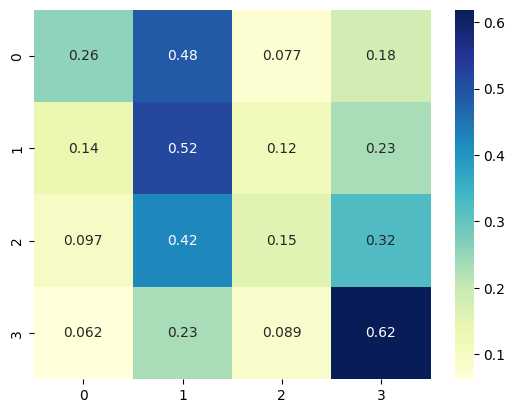

In [394]:
our_metrics(y_train_dogs, y_pred_train_dogs, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4037
_____________________
Weighted Quadratic Kappa: 0.2978


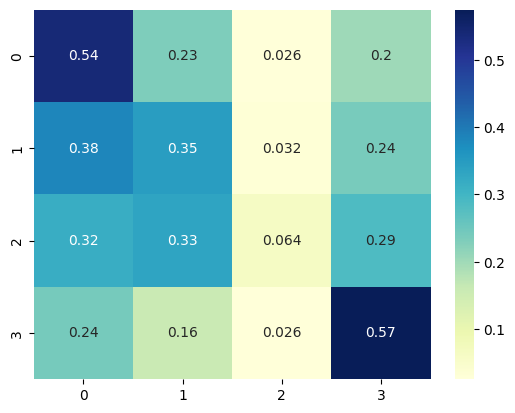

In [395]:
our_metrics(y_test_cats, y_pred_test_cats, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3992
_____________________
Weighted Quadratic Kappa: 0.3241


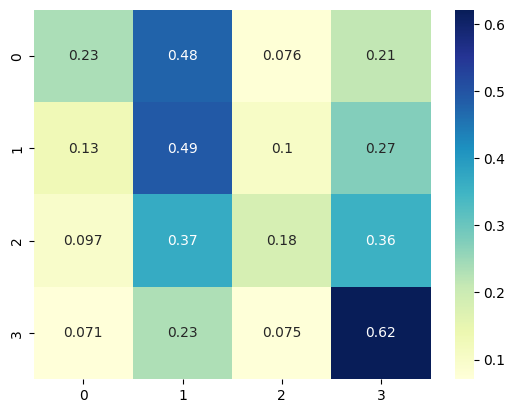

In [396]:
our_metrics(y_test_dogs, y_pred_test_dogs, normalize=True)

## Hyperparameter Tuning with Random Search

### Accuracy Scorer

In [133]:
#what parameters does LogisticRegression have?
log_reg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

### Hyperparameters of the LogisticRegression

- 'C' : float, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- 'class_weight' : dict or ‘balanced’, default=None
Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.
- 'dual' : bool, default=False
Dual or primal formulation. Dual formulation is only implemented for l2 penalty with liblinear solver. Prefer dual=False when n_samples > n_features.
- 'fit_intercept' : bool, default=True
Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
- 'intercept_scaling' : float, default=1
Useful only when the solver ‘liblinear’ is used and ...
- 'l1_ratio': float, default=None
The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.
- 'max_iter' : int, default=100
Maximum number of iterations taken for the solvers to converge
- 'multi_class': {‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’
If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.
- n_jobs': int, default=None
- 'penalty' : {‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’
- 'random_state' : int, RandomState instance, default=None
Used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data.
- 'solver' : {‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’
Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:
For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
‘liblinear’ is limited to one-versus-rest schemes.
‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Note that it is limited to binary classification and the one-versus-rest reduction for multiclass classification. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix.
Warning: The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:
‘lbfgs’ - [‘l2’, None]
‘liblinear’ - [‘l1’, ‘l2’]
‘newton-cg’ - [‘l2’, None]
‘newton-cholesky’ - [‘l2’, None]
‘sag’ - [‘l2’, None]
‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]
- 'tol' : float, default=1e-4
Tolerance for stopping criteria.
- 'verbose' : int, default=0
For the liblinear and lbfgs solvers set verbose to any positive number for verbosity.
- 'warm_start' : bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. Useless for liblinear solver.

### Hyperparameter Tuning for Cats

In [264]:
 # Define parameter grid for randomized search
param_grid_cats = {'C' : loguniform(1e-5, 200),
#              'C' : np.linspace(0.001, 10, 50),
#              'l1_ratio' : np.linspace(0, 1, 20), 
              'penalty' : ['l1', 'l2', 'elasticnet'],#, None],
              'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
             }

In [409]:
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [440]:
#multi_class=‘auto’/‘multinomial’ multi_class='multinomial'
# Instantiate random search and define the metric to optimize 
rs_cats = RandomizedSearchCV(LogisticRegression(random_state=RSEED,max_iter=1000), param_grid_cats, scoring='accuracy',
                  cv=5, verbose=0, n_jobs=-1, n_iter=40, random_state=RSEED)#cv=5

In [441]:
# Fit randomized search object to data
rs_cats.fit(X_train_cats, y_train_cats)

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, s

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x155973610>,
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42, scoring='accuracy')

In [442]:
# Best score
print('Best score:', round(rs_cats.best_score_, 3))

# Best parameters
print('Best parameters:', rs_cats.best_params_)

Best score: 0.367
Best parameters: {'C': 15.77412560608475, 'penalty': 'l1', 'solver': 'liblinear'}


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4053
_____________________
Weighted Quadratic Kappa: 0.2921


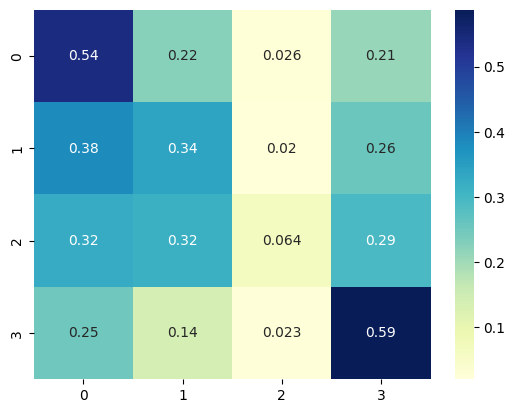

In [443]:
# Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs
log_reg_best_rs_cats = rs_cats.best_estimator_

# Making predictions on the test set
y_pred_test_rs_cats = log_reg_best_rs_cats.predict(X_test_cats)

# Let us print out the performance of our model on the test set.
our_metrics(y_test_cats, y_pred_test_rs_cats, normalize=True)

### Hyperparameter Tuning for Dogs

In [470]:
# Define parameter grid for randomized search
param_grid_dogs = {'C' : loguniform(1e-5, 200),
              #'C' : np.linspace(0.001, 10, 50),
#              'l1_ratio' : np.linspace(0, 1, 20), 
              'penalty' : ['l1', 'l2', 'elasticnet', None],
              'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
             }
#multi_class=‘auto’/‘multinomial’ multi_class='multinomial'

In [471]:
# Instantiate random search and define the metric to optimize 
rs_dogs = RandomizedSearchCV(LogisticRegression(random_state=RSEED,max_iter=1000), param_grid_dogs, scoring='accuracy',
                  cv=cv, verbose=0, n_jobs=-1, n_iter=40, random_state=RSEED)
# Fit randomized search object to data
rs_dogs.fit(X_train_dogs, y_train_dogs)

Fitting 30 folds for each of 40 candidates, totalling 1200 fits


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x155d23dd0>,
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42, scoring='accuracy', verbose=1)

In [472]:
# Best score
print('Best score:', round(rs_dogs.best_score_, 3))

# Best parameters
print('Best parameters:', rs_dogs.best_params_)

Best score: 0.397
Best parameters: {'C': 4.926600882866541, 'penalty': 'l1', 'solver': 'liblinear'}


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4004
_____________________
Weighted Quadratic Kappa: 0.3225


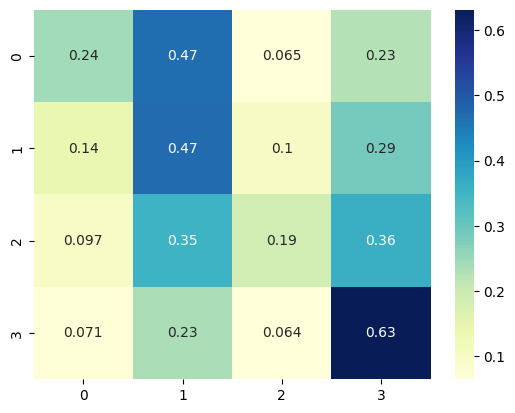

In [473]:
# Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs
log_reg_best_rs_dogs = rs_dogs.best_estimator_

# Making predictions on the test set
y_pred_test_rs_dogs = log_reg_best_rs_dogs.predict(X_test_dogs)

# Let us print out the performance of our model on the test set.
our_metrics(y_test_dogs, y_pred_test_rs_dogs, normalize=True)

### Combined Hypertuning

In [474]:
 # Define parameter grid for randomized search
param_grid = {#'C' : loguniform(1e-5, 200),
              'C' : np.linspace(0.1, 10, 50),
#              'l1_ratio' : np.linspace(0, 1, 20), 
              'penalty' : ['l1', 'l2', 'elasticnet', None],
              'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
             }

In [475]:
#multi_class=‘auto’/‘multinomial’ multi_class='multinomial'
# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(LogisticRegression(random_state=RSEED,max_iter=1000), param_grid, scoring='accuracy',
                  cv=5, verbose=1, n_jobs=-1, n_iter=40, random_state=RSEED)

In [476]:
# Fit randomized search object to data
rs.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'C': array([ 0.1       ,  0.30204082,  0.50408163,  0.70612245,  0.90816327,
        1.11020408,  1.3122449 ,  1.51428571,  1.71632653,  1.91836735,
        2.12040816,  2.32244898,  2.5244898 ,  2.72653061,  2.92857143,
        3.13061224,  3.33265306,  3.53469388,  3.73673469,  3.93877551,
        4.1...
        6.16122449,  6.36326531,  6.56530612,  6.76734694,  6.96938776,
        7.17142857,  7.37346939,  7.5755102 ,  7.77755102,  7.97959184,
        8.18163265,  8.38367347,  8.58571429,  8.7877551 ,  8.98979592,
        9.19183673,  9.39387755,  9.59591837,  9.79795918, 10.        ]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42, scoring='accuracy', verbose=1)

In [477]:
# Best score
print('Best score:', round(rs.best_score_, 3))

# Best parameters
print('Best parameters:', rs.best_params_)

Best score: 0.382
Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.5040816326530613}


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3907
_____________________
Weighted Quadratic Kappa: 0.2987


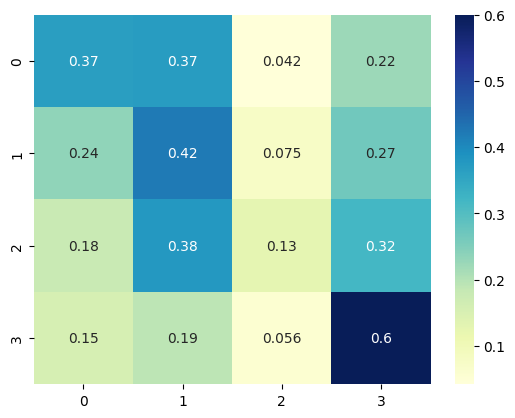

In [478]:
# Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs
log_reg_best_rs = rs.best_estimator_

# Making predictions on the test set
y_pred_test_rs = log_reg_best_rs.predict(X_test)

# Let us print out the performance of our model on the test set.
our_metrics(y_test, y_pred_test_rs, normalize=True)

## RandomSearch with Quadratic Weighted Kappa Scorer

In [504]:
# # make the kappa scorers needed for the grid search
# kappa_scorer = get_kappa()

In [505]:
# # #multi_class=‘auto’/‘multinomial’
# # Instantiate random search and define the metric to optimize 
# rs_kappa = RandomizedSearchCV(LogisticRegression(random_state=RSEED,max_iter=1000), param_grid, scoring=kappa_scorer,
#                   cv=5, verbose=0, n_jobs=-1, n_iter=50, random_state=RSEED)

In [506]:
# # Fit randomized search object to data
# rs_kappa.fit(X_train, y_train)

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([ 0.1       ,  0.30204082,  0.50408163,  0.70612245,  0.90816327,
        1.11020408,  1.3122449 ,  1.51428571,  1.71632653,  1.91836735,
        2.12040816,  2.32244898,  2.5244898 ,  2.72653061,  2.92857143,
        3.13061224,  3.33265306,  3.53469388,  3.73673469,  3.93877551,
        4.1...
        6.16122449,  6.36326531,  6.56530612,  6.76734694,  6.96938776,
        7.17142857,  7.37346939,  7.5755102 ,  7.77755102,  7.97959184,
        8.18163265,  8.38367347,  8.58571429,  8.7877551 ,  8.98979592,
        9.19183673,  9.39387755,  9.59591837,  9.79795918, 10.        ]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42,
                   scoring=make_scorer(cohen_kappa_score, weights=quadratic))

In [507]:
# # Best score
# print('Best score:', round(rs_kappa.best_score_, 3))

# # Best parameters
# print('Best parameters:', rs_kappa.best_params_)

Best score: 0.286
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.9081632653061225}


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3928
_____________________
Weighted Quadratic Kappa: 0.2951


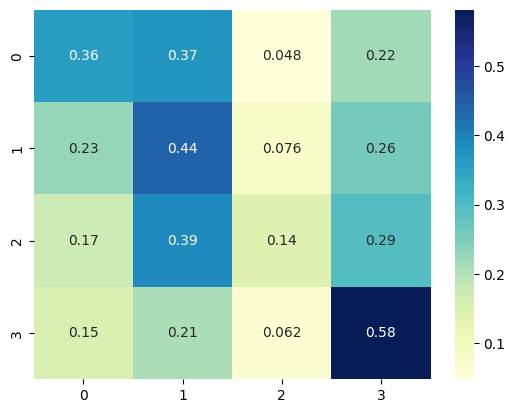

In [508]:
# # Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs_kappa
# log_reg_best_rs_kappa = rs_kappa.best_estimator_

# # Making predictions on the test set
# y_pred_test_rs_kappa = log_reg_best_rs_kappa.predict(X_test)

# # Let us print out the performance of our model on the test set.
# our_metrics(y_test, y_pred_test_rs_kappa, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.388
_____________________
Weighted Quadratic Kappa: 0.291


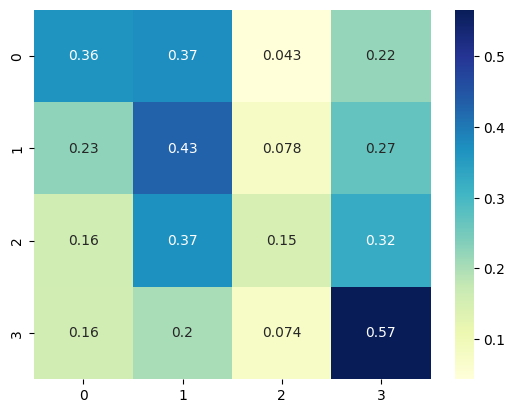

In [509]:
# y_pred_train_rs_kappa = log_reg_best_rs_kappa.predict(X_train)
# our_metrics(y_train, y_pred_train_rs_kappa, normalize=True)

## GridSearch

In [521]:
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [550]:
# Defining parameter grid (as dictionary)
param_grid = {"C" : [0.4,0.5,0.6, 0.75,1,1.25,1.5,2, 4],
              "penalty" : ["l2", "l1", 'elasticnet', None],
              'solver' : ['lbfgs', 'saga', 'liblinear']
             }

In [551]:
# Instantiate gridsearch and define the metric to optimize 
gs_cats = GridSearchCV(LogisticRegression(random_state=RSEED), param_grid, scoring='accuracy',
                  cv=5, verbose=0, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
gs_cats.fit(X_train_cats, y_train_cats)

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.4, 0.5, 0.6, 0.75, 1, 1.25, 1.5, 2, 4],
                         'penalty': ['l2', 'l1', 'elasticnet', None],
                         'solver': ['lbfgs', 'saga', 'liblinear']},
             scoring='accuracy')

In [552]:
# Best score
print('Best score:', round(gs_cats.best_score_, 3))

# Best parameters
print('Best parameters:', gs_cats.best_params_)

Best score: 0.368
Best parameters: {'C': 1.5, 'penalty': 'l1', 'solver': 'liblinear'}


In [553]:
# Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs_kappa
log_reg_best_gs_cats = gs_cats.best_estimator_

# Making predictions on the test set
y_pred_test_gs_cats = log_reg_best_gs_cats.predict(X_test_cats)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4045
_____________________
Weighted Quadratic Kappa: 0.2956


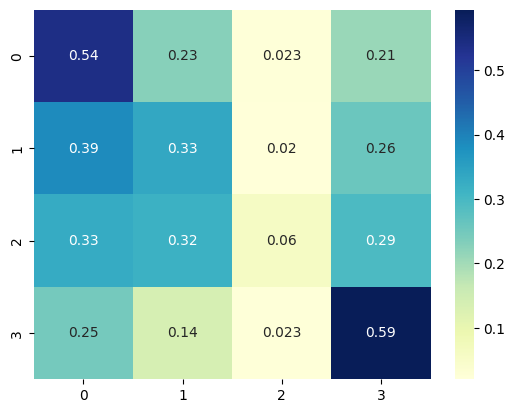

In [554]:
our_metrics(y_test_cats, y_pred_test_gs_cats, normalize=True)

In [555]:
# test_proba_49 = class_metrics_var_threshold(eec_best, X_test_tree, y_test_tree, threshold=0.49)
# Changing the threshold slightly does not improve the model:
# * changing the threshold to 0.6 is equivalent to predicting no one commits fraud
# * changing the threshold to 0.49 yields a lot of true positives, hardly any false negatives. However, this comes at the price of a lot of false positive predictions. 
# # get scorers for different thresholds
# test_proba = class_metrics_var_threshold(eec_best, X_test_tree, y_test_tree, threshold=0.5)

## Splitting Cats and Dogs, Combine Target 2 & 3

Combining Targets 2 and 3 did not turn out to be helpful: For LogisticRegression, combining the middle two categories creates imbalanced data problems (the middle category then is represented twice as often as the other two, roughly), which makes the model lean towards predicting the middle category. I.e., performance on target 1 and 4 observation really suffers when combining targets 2 and 3. So for Logistic Regression, we will not pursue this any further but rather stick with 4 target categories.

In [556]:
# combine Target 2 and 3
y_train_cats_comb = [2 if x == 3 else x for x in y_train_cats]
y_test_cats_comb = [2 if x == 3 else x for x in y_test_cats]
y_train_dogs_comb = [2 if x == 3 else x for x in y_train_dogs]
y_test_dogs_comb = [2 if x == 3 else x for x in y_test_dogs]

In [557]:
# print(np.unique(y_test_dogs_comb, return_counts=True))
# print(np.unique(y_test_cats_comb, return_counts=True))

In [558]:
# Logistic Regression
log_reg_cats_comb = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_cats_comb.fit(X_train_cats, y_train_cats_comb)

log_reg_dogs_comb = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_dogs_comb.fit(X_train_dogs, y_train_dogs_comb)

y_pred_train_cats_comb = log_reg_cats_comb.predict(X_train_cats)
y_pred_test_cats_comb = log_reg_cats_comb.predict(X_test_cats)

y_pred_train_dogs_comb = log_reg_dogs_comb.predict(X_train_dogs)
y_pred_test_dogs_comb = log_reg_dogs_comb.predict(X_test_dogs)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4411
_____________________
Weighted Quadratic Kappa: 0.2685


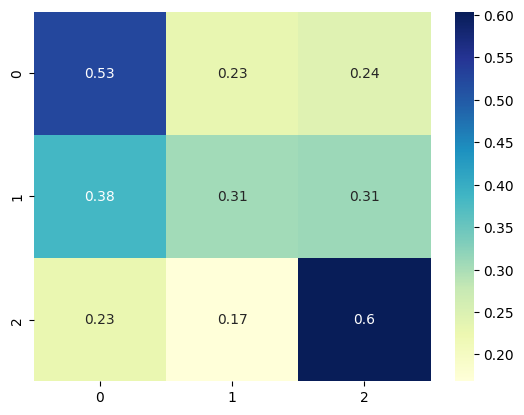

In [559]:
# train data
our_metrics(y_train_cats_comb, y_pred_train_cats_comb, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4815
_____________________
Weighted Quadratic Kappa: 0.3413


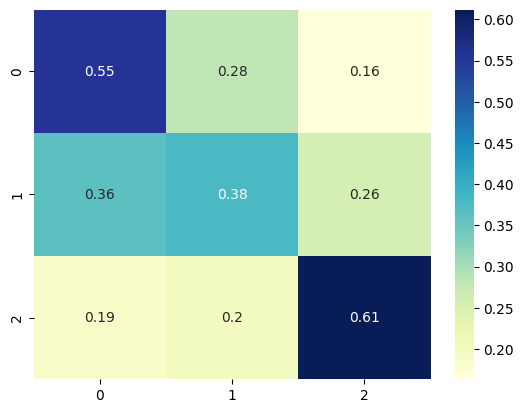

In [560]:
our_metrics(y_train_dogs_comb, y_pred_train_dogs_comb, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4725
_____________________
Weighted Quadratic Kappa: 0.3033


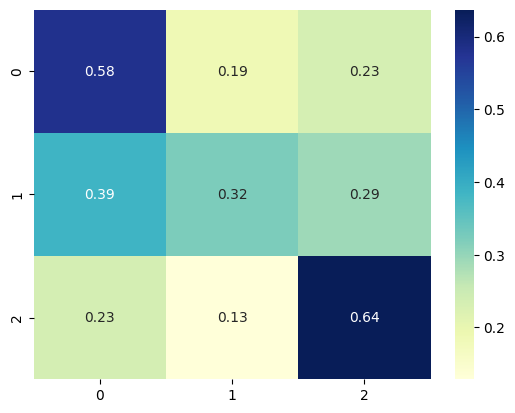

In [561]:
# test data
our_metrics(y_test_cats_comb, y_pred_test_cats_comb, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4698
_____________________
Weighted Quadratic Kappa: 0.3101


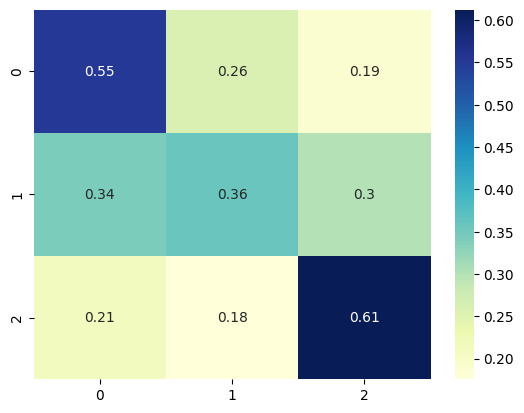

In [562]:
our_metrics(y_test_dogs_comb, y_pred_test_dogs_comb, normalize=True)

In [563]:
# # define evaluation
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

## All or Nothing

In [564]:
# combine Target 2 and 3
y_train_cats_comb2 = [0 if x <= 3 else 1 for x in y_train_cats]
y_test_cats_comb2 = [0 if x <= 3 else 1 for x in y_test_cats]
y_train_dogs_comb2 = [0 if x <= 3 else 1 for x in y_train_dogs]
y_test_dogs_comb2 = [0 if x <= 3 else 1 for x in y_test_dogs]

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6712
_____________________
Weighted Quadratic Kappa: 0.2755
Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.7187
_____________________
Weighted Quadratic Kappa: 0.3605
Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6926
_____________________
Weighted Quadratic Kappa: 0.3194
Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6896
_____________________
Weighted Quadratic Kappa: 0.3098


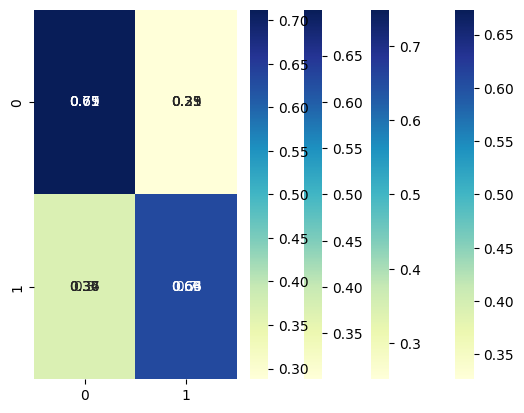

In [565]:

# print(np.unique(y_test_dogs_comb2, return_counts=True))
# print(np.unique(y_test_cats_comb2, return_counts=True))
# Logistic Regression
log_reg_cats_comb2 = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_cats_comb2.fit(X_train_cats, y_train_cats_comb2)

log_reg_dogs_comb2 = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_dogs_comb2.fit(X_train_dogs, y_train_dogs_comb2)

y_pred_train_cats_comb2 = log_reg_cats_comb2.predict(X_train_cats)
y_pred_test_cats_comb2 = log_reg_cats_comb2.predict(X_test_cats)

y_pred_train_dogs_comb2 = log_reg_dogs_comb2.predict(X_train_dogs)
y_pred_test_dogs_comb2 = log_reg_dogs_comb2.predict(X_test_dogs)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6712
_____________________
Weighted Quadratic Kappa: 0.2755


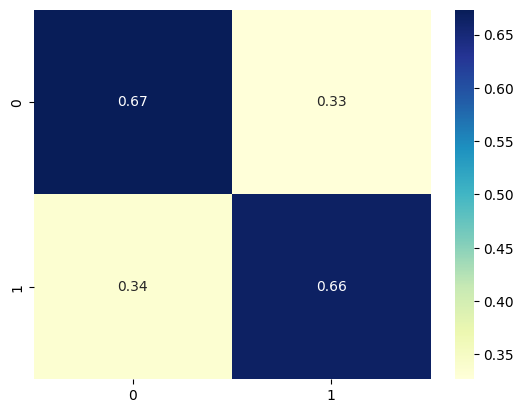

In [566]:
# train data
our_metrics(y_train_cats_comb2, y_pred_train_cats_comb2, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.7187
_____________________
Weighted Quadratic Kappa: 0.3605


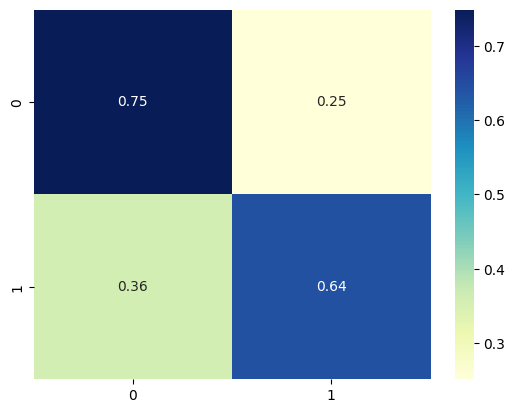

In [567]:
our_metrics(y_train_dogs_comb2, y_pred_train_dogs_comb2, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6926
_____________________
Weighted Quadratic Kappa: 0.3194


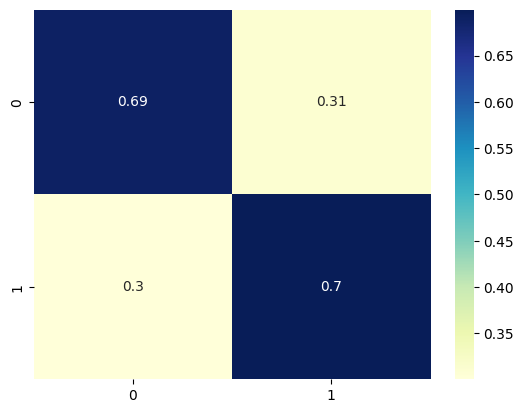

In [568]:
# test data
our_metrics(y_test_cats_comb2, y_pred_test_cats_comb2, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6896
_____________________
Weighted Quadratic Kappa: 0.3098


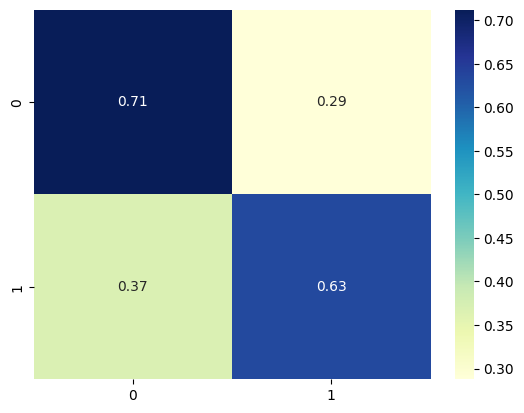

In [569]:
our_metrics(y_test_dogs_comb2, y_pred_test_dogs_comb2, normalize=True)

In [571]:
log_reg_cats_comb2.coef_

array([[ 8.35286719e-05, -4.53582761e-01, -7.64804340e-02,
         1.58679452e-01,  4.15149981e-01, -4.88568907e-02,
         4.89404194e-02,  4.92309417e-01,  3.33966265e-01,
         1.40075209e-01, -9.66267362e-01,  4.05975492e-01,
         3.10239354e-01, -7.16131317e-01, -4.49611463e-01,
        -1.72687599e-01,  6.22382591e-01,  5.85346304e-02,
        -1.72394876e-01,  1.13943774e-01, -1.32375022e+00,
         2.41865018e+00, -1.39260138e+00]])

In [570]:
log_reg_dogs_comb2.coef_

array([[ 0.        , -0.45979881,  2.06155733, -0.0599353 ,  0.29738096,
         0.20223331, -0.06340999, -0.22380464, -1.75252455, -0.24761734,
        -0.82809219,  0.53472241,  0.50997143, -0.17748543, -0.08123627,
        -1.44779004,  2.42779262, -0.96348707]])

In [573]:
X_train_cats.shape

(3707, 23)

In [572]:
X_train_dogs.shape

(4966, 18)